<a href="https://colab.research.google.com/github/Griffinw15/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [0]:
df['created_in_dt'] = pd.to_datetime(df['created'])

In [4]:
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,created_in_dt
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-06-24 07:54:24
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-06-12 12:19:27
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-04-17 03:26:41
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-04-18 02:22:02
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-04-28 01:32:41


In [5]:
df.dtypes

bathrooms                      float64
bedrooms                         int64
created                         object
description                     object
display_address                 object
latitude                       float64
longitude                      float64
price                            int64
street_address                  object
interest_level                  object
elevator                         int64
cats_allowed                     int64
hardwood_floors                  int64
dogs_allowed                     int64
doorman                          int64
dishwasher                       int64
no_fee                           int64
laundry_in_building              int64
fitness_center                   int64
pre-war                          int64
laundry_in_unit                  int64
roof_deck                        int64
outdoor_space                    int64
dining_room                      int64
high_speed_internet              int64
balcony                  

In [0]:
#Does it have any laundry at all?

def laundry(df):
    if (df['laundry_in_unit']==1) or (df['laundry_in_building']==1):
        return "1"
    else:
        return "0"
# Apply the function
df['any_laundry'] = df.apply(laundry, axis=1)

In [0]:
#Does it have an outdoor space/feature? 

def outdoors(df):
    if (df['common_outdoor_space']==1) or (df['garden_patio']==1 or df['terrace']==1) or (df['balcony']==1 or df['outdoor_space']==1) or (df['roof_deck']==1):
        return "1"
    else:
        return "0"
# Apply the function
df['any_outdoor'] = df.apply(outdoors, axis=1)

In [0]:
#df['any_outdoor'] = df[(df['any_outdoor'].astype(int))]

In [0]:
#df['any_outdoor'] = df['any_outdoor'].astype(int)

In [0]:
df['any_outdoor'] = pd.to_numeric(df['any_outdoor'])

In [0]:
df['any_laundry'] = pd.to_numeric(df['any_outdoor'])

In [12]:
df.tail()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,created_in_dt,any_laundry,any_outdoor
49347,1.0,2,2016-06-02 05:41:05,"30TH/3RD, MASSIVE CONV 2BR IN LUXURY FULL SERV...",E 30 St,40.7426,-73.9790,3200,230 E 30 St,medium,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-06-02 05:41:05,0,0
49348,1.0,1,2016-04-04 18:22:34,"HIGH END condo finishes, swimming pool, and ki...",Rector Pl,40.7102,-74.0163,3950,225 Rector Place,low,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,2016-04-04 18:22:34,1,1
49349,1.0,1,2016-04-16 02:13:40,Large Renovated One Bedroom Apartment with Sta...,West 45th Street,40.7601,-73.9900,2595,341 West 45th Street,low,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-04-16 02:13:40,0,0
49350,1.0,0,2016-04-08 02:13:33,Stylishly sleek studio apartment with unsurpas...,Wall Street,40.7066,-74.0101,3350,37 Wall Street,low,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-04-08 02:13:33,0,0
49351,1.0,2,2016-04-12 02:48:07,Look no further!!! This giant 2 bedroom apart...,Park Terrace East,40.8699,-73.9172,2200,30 Park Terrace East,low,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-04-12 02:48:07,0,0


In [0]:
train = df[(df['created_in_dt'] >= '2016-04-01') & (df['created_in_dt'] < '2016-06-01')]
test = df[(df['created_in_dt'] >= '2016-06-01') & (df['created_in_dt'] < '2016-07-01')]

In [14]:
train['price'].mean()

3575.604007034292

In [0]:
# Arrange y target vectors
target = 'price'
y_train = train[target]
y_test = test[target]

In [16]:
# Get mean baseline
print('Mean Baseline (using no features)')
guess = y_train.mean()
print (guess)

Mean Baseline (using no features)
3575.604007034292


In [17]:
# Train Error
from sklearn.metrics import mean_absolute_error
y_pred = [guess] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error (April-May 2016 Listings): {mae:.2f} dollars/month')

Train Error (April-May 2016 Listings): 1201.88 dollars/month


In [18]:
# Test Error
y_pred = [guess] * len(y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Error (June 2016 Listings): {mae:.2f} dollars/month')

Test Error (June 2016 Listings): 1197.71 dollars/month


In [19]:
import plotly.express as px

px.scatter_3d(train, x='any_laundry',y='any_outdoor', z='price')

In [0]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [0]:
target = 'price'

features = ['any_laundry', 'any_outdoor']

X_train = train[features]
X_test = test[features]
y_train = train[target]

In [22]:
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error: {mae:.2f} percentage points')

Train Error: 1179.59 percentage points


In [23]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Error: {mae:.2f} percentage points')

Test Error: 1169.73 percentage points


In [24]:
model.intercept_, model.coef_

(3384.979007034292, array([ 2.67906373e+15, -2.67906373e+15]))

In [25]:
beta0 = model.intercept_
beta1, beta2 = model.coef_
print(f'y = {beta0} + {beta1}x1 + {beta2}x2')


y = 3384.979007034292 + 2679063734428906.5x1 + -2679063734428168.5x2


In [26]:
# 'Easier to read' way
print('Intercept', model.intercept_)
coefficients = pd.Series(model.coef_, features)
print(coefficients.to_string())

Intercept 3384.979007034292
any_laundry    2.679064e+15
any_outdoor   -2.679064e+15


In [0]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [0]:
target = 'price'

def squared_errors(df, feature, target, m, b):
    """
    Visualize linear regression, with squared errors,
    in 2D: 1 feature + 1 target.
    
    Use the m & b parameters to "fit the model" manually.
    
    df : Pandas DataFrame
    feature : string, feature column in df
    target : string, target column in df
    m : numeric, slope for linear equation
    b : numeric, intercept for linear requation
    """
    
    # Plot data
    fig = plt.figure(figsize=(20, 20))
    ax = plt.axes()
    df.plot.scatter(feature, target, ax=ax)
    
    # Make predictions
    x = df[feature]
    y = df[target]
    y_pred = m*x + b
    
    # Plot predictions
    ax.plot(x, y_pred)
    
    # Plot squared errors
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    scale = (xmax-xmin)/(ymax-ymin)
    for x, y1, y2 in zip(x, y, y_pred):
        bottom_left = (x, min(y1, y2))
        height = abs(y1 - y2)
        width = height * scale
        ax.add_patch(Rectangle(xy=bottom_left, width=width, height=height, alpha=0.1))
    
    # Print regression metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)

In [29]:
df.dtypes

bathrooms                      float64
bedrooms                         int64
created                         object
description                     object
display_address                 object
latitude                       float64
longitude                      float64
price                            int64
street_address                  object
interest_level                  object
elevator                         int64
cats_allowed                     int64
hardwood_floors                  int64
dogs_allowed                     int64
doorman                          int64
dishwasher                       int64
no_fee                           int64
laundry_in_building              int64
fitness_center                   int64
pre-war                          int64
laundry_in_unit                  int64
roof_deck                        int64
outdoor_space                    int64
dining_room                      int64
high_speed_internet              int64
balcony                  

Mean Squared Error: 3105028.217891242
Root Mean Squared Error: 1762.1090255404863
Mean Absolute Error: 1201.8811133682555
R^2: 0.0


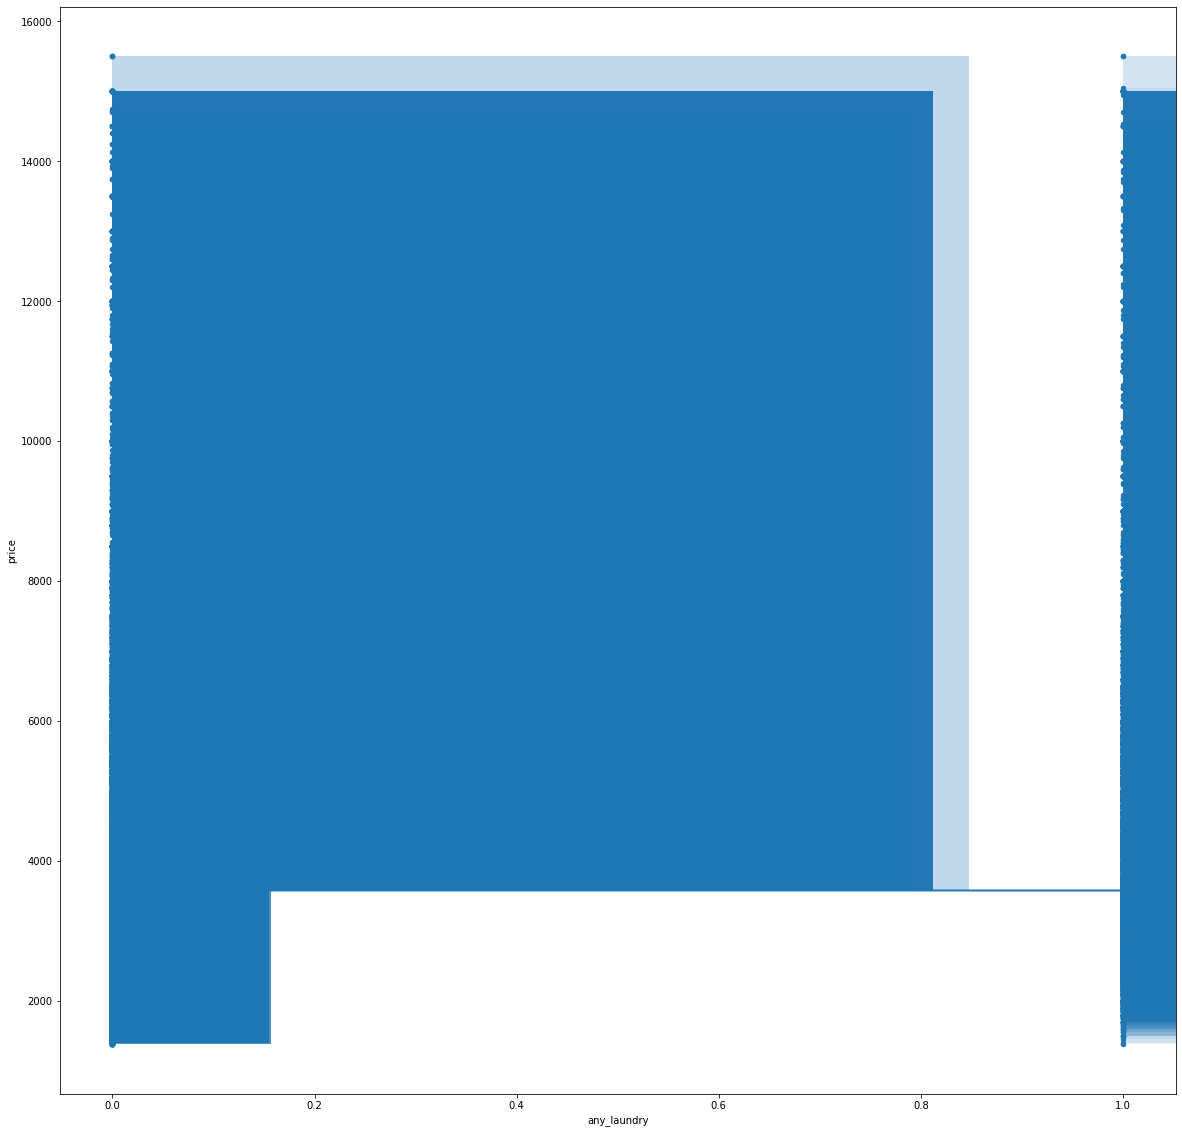

In [30]:
feature = 'any_laundry'

squared_errors(train, feature, target, m=0, b=y_train.mean())

Mean Squared Error: 3105350.7270757444
Root Mean Squared Error: 1762.2005354316927
Mean Absolute Error: 1208.733858811707
R^2: -0.00010386674834195198


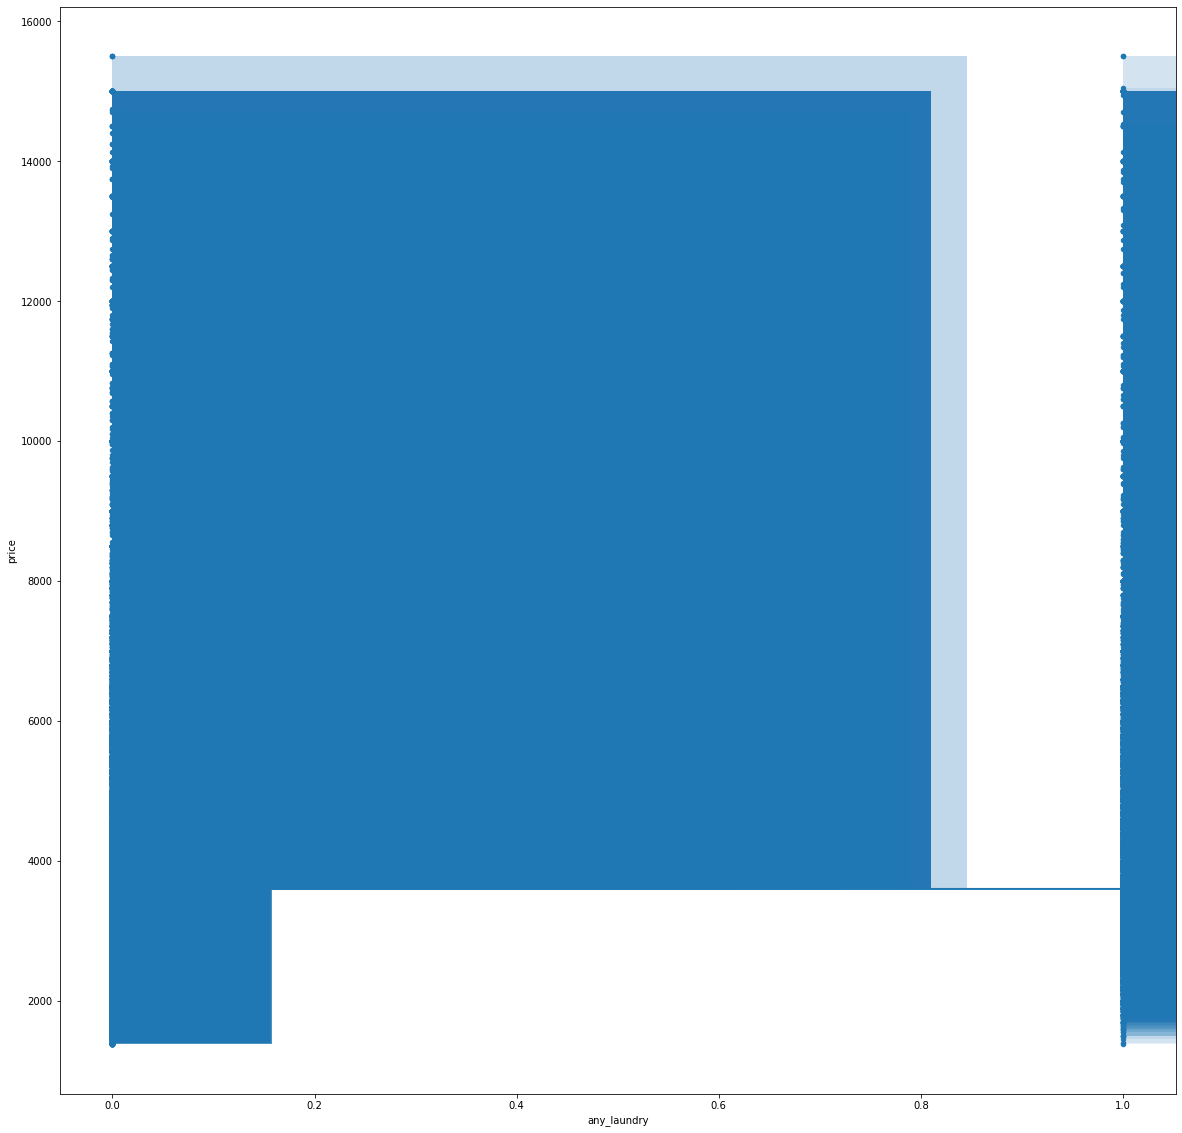

In [33]:
feature = 'any_laundry'

squared_errors(train, feature, target, m=1, b=3600)

Mean Squared Error: 3105385.3050182136
Root Mean Squared Error: 1762.210346416742
Mean Absolute Error: 1194.8427647280491
R^2: -0.00011500286049392905


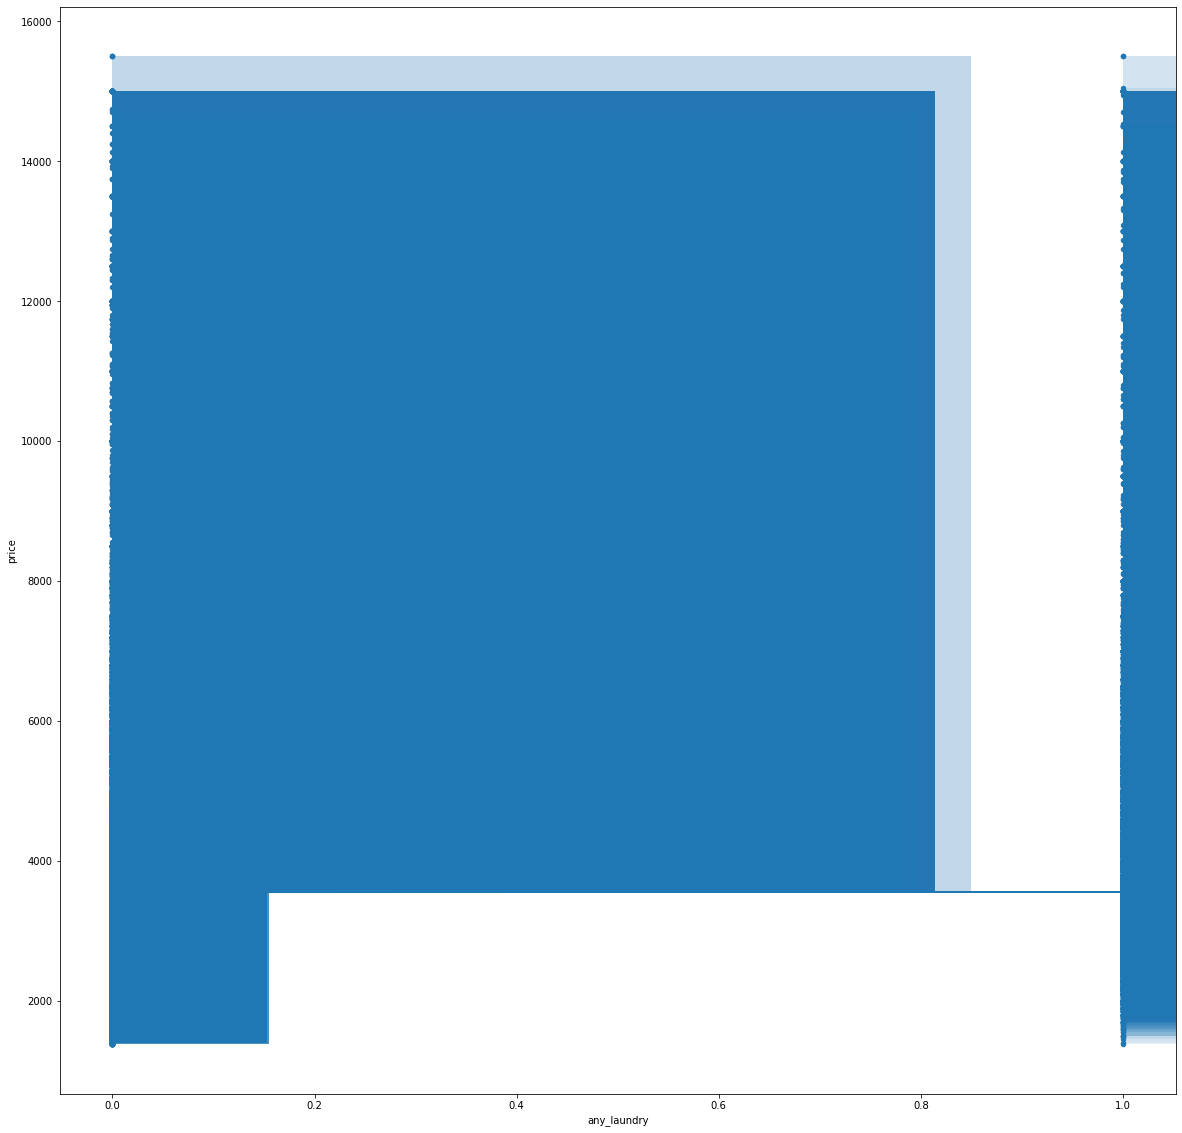

In [34]:
feature = 'any_laundry'

squared_errors(train, feature, target, m=1, b=3550)